In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import datetime

import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [2]:
df=pd.read_csv('Britania Ltd.csv',encoding='ISO-8859-1')
df.head()

,Date,Location,Text,Username,Like Count,Retweet Count,Follower Count
0,2023-03-27 23:57:08+00:00,NaN,@MmmmTrams @Malcolm02792388 @toryboypierce And...,petepedwards,1.0,0.0,49.0
1,2023-03-27 23:29:38+00:00,"Ballenger Creek, MD","Rule, Britannia!",jws4220,0.0,0.0,73.0
2,2023-03-27 23:19:00+00:00,Unknown,The Official Roll Britannia Shop is full of yo...,MalrusTheCleric,0.0,0.0,3445.0
3,2023-03-27 23:10:41+00:00,Earth,@ShehabKhan Itâs Cool Britannia,bf7216,0.0,0.0,190.0
4,2023-03-27 23:10:01+00:00,UK,The Official Roll Britannia Shop is full of yo...,RollBritannia,0.0,0.0,4681.0


In [3]:
df.columns

Index(['Date', 'Location', 'Text', 'Username', 'Like Count', 'Retweet Count',
       'Follower Count'],
      dtype='object')

In [4]:
# Drop Username column
df.drop('Username',inplace=True,axis=1)

In [5]:
# Check any missing values
df.isnull().sum()

Date                  2
Location          10364
Text                 16
Like Count           54
Retweet Count        56
Follower Count       56
dtype: int64

In [6]:
for col in df.columns:
    print(col,':',(df[col].isnull().sum()/len(df))*100,'%')

Date : 0.0038058267207094062 %
Location : 19.721794066716143 %
Text : 0.03044661376567525 %
Like Count : 0.10275732145915396 %
Retweet Count : 0.10656314817986338 %
Follower Count : 0.10656314817986338 %


In [7]:
# Drop Location column
df.drop('Location',inplace=True,axis=1)

In [8]:
# Check any missing values
df.isnull().sum()

Date               2
Text              16
Like Count        54
Retweet Count     56
Follower Count    56
dtype: int64

In [9]:
# Drop the missing values as its count is very less compared to the entire dataset
df.dropna(inplace=True)
len(df)

52495

In [10]:
# Drop the duplicates
df = df.drop_duplicates()
len(df)

52296

In [11]:
# extract hashtags from the Text column
hashtags = []
for text in df['Text']:
    hashtags += re.findall(r'#\w+', text)

# count the frequency of each hashtag
freq = Counter(hashtags)

# sort the hashtags by frequency
sorted_hashtags = sorted(freq.items(), key=lambda x: x[1], reverse=True)

# extract the top 20 hashtags
top_20_hashtags = sorted_hashtags[:20]

# print the top 20 hashtags with their frequency
for hashtag, count in top_20_hashtags:
    print(f"{hashtag}: {count}")

#WhenOatsMetChocolate: 4346
#cheesesandwich: 4341
#12HourChallenge: 1905
#LittleHearts: 1896
#12HourChallenge2018: 1725
#BritanniaIndustries: 1363
#CheeseSandwich: 1159
#investing: 1049
#Britannia: 999
#littlehearts: 980
#StockMarket: 863
#Giveaway: 772
#BookTour: 770
#Contemporary: 768
#Romance: 768
#Win: 763
#BookBoost: 763
#SnackerCrackerContest: 613
#DnD: 601
#æ: 573


In [12]:
# Remove URLs, mentions, and hashtags
def remove_twitter_elements(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    return tweet

df['Text'] = df['Text'].apply(remove_twitter_elements)

In [13]:
#removing emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['Text'] = df['Text'].apply(remove_emojis)

In [14]:
#removing punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['Text'] = df['Text'].apply(remove_punctuation)

In [15]:
# Remove special characters 
def remove_special_characters(tweet):
    tweet = re.sub('[^a-zA-Z0-9\s]', '', tweet)
    return tweet

df['Text'] = df['Text'].apply(remove_special_characters)

In [16]:
# converting to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

In [17]:
# Tokenize the text
def tokenize(tweet):
    tokens = nltk.word_tokenize(tweet)
    return tokens

df['Text'] = df['Text'].apply(tokenize)

In [18]:
# Remove stop words
def remove_stop_words(tokens):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words.update(['britannia','amp','im','start','one'])
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

df['Text'] = df['Text'].apply(remove_stop_words)

In [19]:
# Stemming or Lemmatization
def stem_tokens(tokens):
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

df['Text'] = df['Text'].apply(stem_tokens)

In [20]:
# Normalize case
def normalize_case(tokens):
    normalized_tokens = [token.lower() for token in tokens]
    return normalized_tokens

df['Text'] = df['Text'].apply(normalize_case)

In [21]:
# join tokens back into a single string
def join_text(tweet):
    joined_tweet = " ".join(tweet)
    return joined_tweet

df['Text'] = df['Text'].apply(join_text)

In [22]:
# Convert date to extract Year, Month, Day
df['Date']=pd.to_datetime(df['Date'])

df['Year'] = df['Date'].apply(lambda date:date.year)
df['Month'] = df['Date'].apply(lambda date:date.month)
df['Day']=df['Date'].apply(lambda date:date.day)
df['Date'] = df['Date'].dt.date

In [23]:
df.head()

,Date,Text,Like Count,Retweet Count,Follower Count,Year,Month,Day
0,2023-03-27,lot hotel certsin chain couldnt get tourist st...,1.0,0.0,49.0,2023,3,27
1,2023-03-27,rule,0.0,0.0,73.0,2023,3,27
2,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,3445.0,2023,3,27
3,2023-03-27,cool,0.0,0.0,190.0,2023,3,27
4,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,4681.0,2023,3,27


In [24]:
#df.drop('Tweet Id',inplace=True,axis=1)

In [25]:
#nltk.download('vader_lexicon')

# initialize VADER
sid = SentimentIntensityAnalyzer()

# define a function to get the sentiment score for each tweet
def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

# apply the function to the 'text' column and create a new 'sentiment_score' column
df['sentiment_score'] = df['Text'].apply(get_sentiment_score)

# print the first 10 rows of the dataframe to verify the results
df.head(10)

,Date,Text,Like Count,Retweet Count,Follower Count,Year,Month,Day,sentiment_score
0,2023-03-27,lot hotel certsin chain couldnt get tourist st...,1.0,0.0,49.0,2023,3,27,0.0000
1,2023-03-27,rule,0.0,0.0,73.0,2023,3,27,0.0000
2,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,3445.0,2023,3,27,0.0000
3,2023-03-27,cool,0.0,0.0,190.0,2023,3,27,0.3182
4,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,4681.0,2023,3,27,0.0000
5,2023-03-27,compet fight take control beyond lie futur hai...,0.0,0.0,160.0,2023,3,27,-0.3182
6,2023-03-27,astonish leader english labour parti could com...,14.0,9.0,18185.0,2023,3,27,-0.5267
7,2023-03-27,prime minster mayor london first minist peopl ...,0.0,0.0,190.0,2023,3,27,0.6597
8,2023-03-27,youngest cousin struck kill hit run creditview...,1.0,0.0,233.0,2023,3,27,-0.8957
9,2023-03-27,dungeon master love leav boy stuck rock hard p...,0.0,0.0,4681.0,2023,3,27,0.4215


In [26]:
# define a function to map the sentiment scores to categories
def get_sentiment_category(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'
    
# map the sentiment scores to categories and create a new 'category' column
df['Polarity'] = df['sentiment_score'].apply(get_sentiment_category)

# print the first 10 rows of the dataframe to verify the results
df.head(10)

,Date,Text,Like Count,Retweet Count,Follower Count,Year,Month,Day,sentiment_score,Polarity
0,2023-03-27,lot hotel certsin chain couldnt get tourist st...,1.0,0.0,49.0,2023,3,27,0.0000,neutral
1,2023-03-27,rule,0.0,0.0,73.0,2023,3,27,0.0000,neutral
2,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,3445.0,2023,3,27,0.0000,neutral
3,2023-03-27,cool,0.0,0.0,190.0,2023,3,27,0.3182,positive
4,2023-03-27,offici roll shop full memorabilia show stylish...,0.0,0.0,4681.0,2023,3,27,0.0000,neutral
5,2023-03-27,compet fight take control beyond lie futur hai...,0.0,0.0,160.0,2023,3,27,-0.3182,negative
6,2023-03-27,astonish leader english labour parti could com...,14.0,9.0,18185.0,2023,3,27,-0.5267,negative
7,2023-03-27,prime minster mayor london first minist peopl ...,0.0,0.0,190.0,2023,3,27,0.6597,positive
8,2023-03-27,youngest cousin struck kill hit run creditview...,1.0,0.0,233.0,2023,3,27,-0.8957,negative
9,2023-03-27,dungeon master love leav boy stuck rock hard p...,0.0,0.0,4681.0,2023,3,27,0.4215,positive


In [27]:
df['Polarity'].value_counts()

positive    24055
neutral     21020
negative     7221
Name: Polarity, dtype: int64

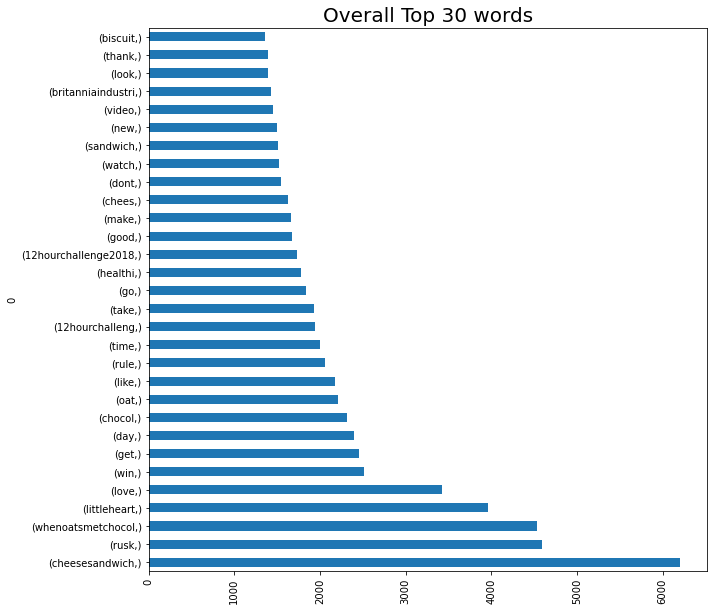

In [28]:
#Overall top 30 words
overall_corpus=[]
for msg in df['Text'].tolist():
    for word in msg.split():
        overall_corpus.append(word)
        
plt.figure(figsize=(10,10))
pd.DataFrame(overall_corpus).value_counts(ascending=False)[0:30].plot(kind='barh')
plt.xticks(rotation='vertical')
plt.title('Overall Top 30 words',size=20)
plt.show()

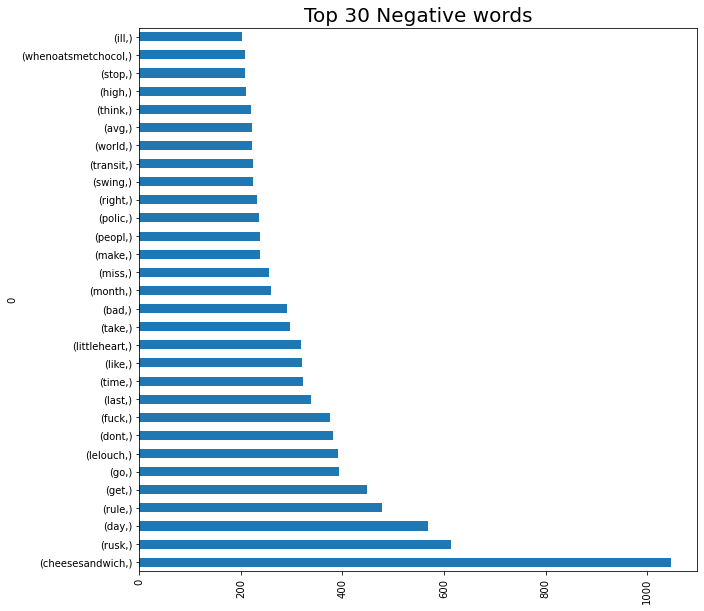

In [29]:
#top negative 30 words
negative_corpus=[]
for msg in df[df['Polarity']=='negative']['Text'].tolist():
    for word in msg.split():
        negative_corpus.append(word)
        
plt.figure(figsize=(10,10))
pd.DataFrame(negative_corpus).value_counts(ascending=False)[0:30].plot(kind='barh')
plt.xticks(rotation='vertical')
plt.title('Top 30 Negative words',size=20)
plt.show()

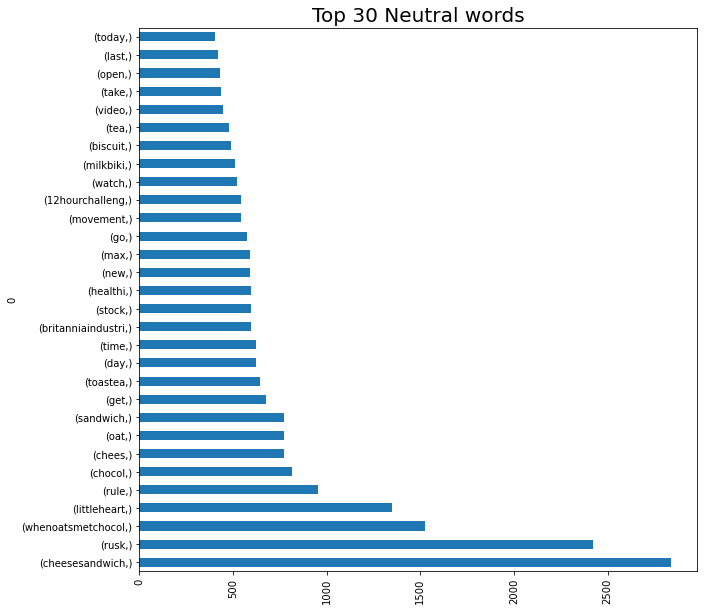

In [30]:
#top neutral 30 words
neutral_corpus=[]
for msg in df[df['Polarity']=='neutral']['Text'].tolist():
    for word in msg.split():
        neutral_corpus.append(word)
        
plt.figure(figsize=(10,10))
pd.DataFrame(neutral_corpus).value_counts(ascending=False)[0:30].plot(kind='barh')
plt.xticks(rotation='vertical')
plt.title('Top 30 Neutral words',size=20)
plt.show()

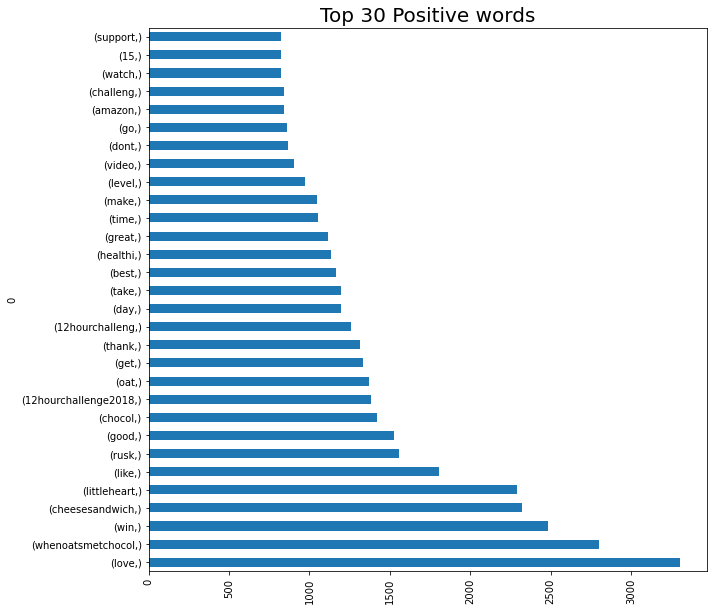

In [31]:
#top positive 30 words
positive_corpus=[]
for msg in df[df['Polarity']=='positive']['Text'].tolist():
    for word in msg.split():
        positive_corpus.append(word)
        
plt.figure(figsize=(10,10))
pd.DataFrame(positive_corpus).value_counts(ascending=False)[0:30].plot(kind='barh')
plt.xticks(rotation='vertical')
plt.title('Top 30 Positive words',size=20)
plt.show()

In [32]:
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')

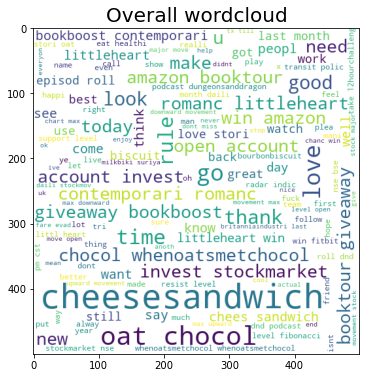

In [33]:
#Overall
overall_wc=wc.generate(df['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,6))
plt.imshow(overall_wc)
plt.title('Overall wordcloud',fontsize=20)
plt.show()

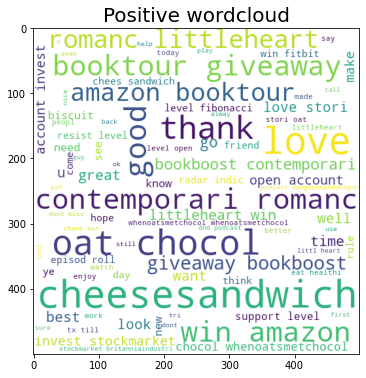

In [34]:
#positive
positive_wc=wc.generate(df[df['Polarity']=='positive']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,6))
plt.imshow(positive_wc)
plt.title('Positive wordcloud',fontsize=20)
plt.show()

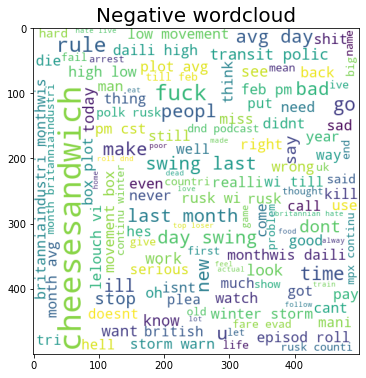

In [35]:
#negative
negative_wc=wc.generate(df[df['Polarity']=='negative']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,6))
plt.imshow(negative_wc)
plt.title('Negative wordcloud',fontsize=20)
plt.show()

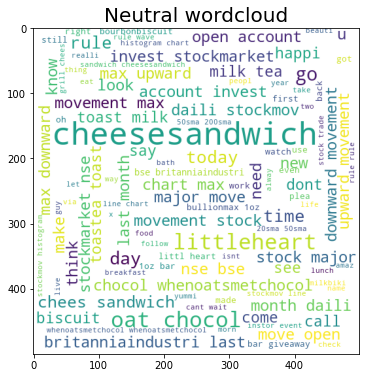

In [37]:
#neutral
neutral_wc=wc.generate(df[df['Polarity']=='neutral']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,6))
plt.imshow(neutral_wc)
plt.title('Neutral wordcloud',fontsize=20)
plt.show()

### Wordcloud after eliminating irrelevant terms

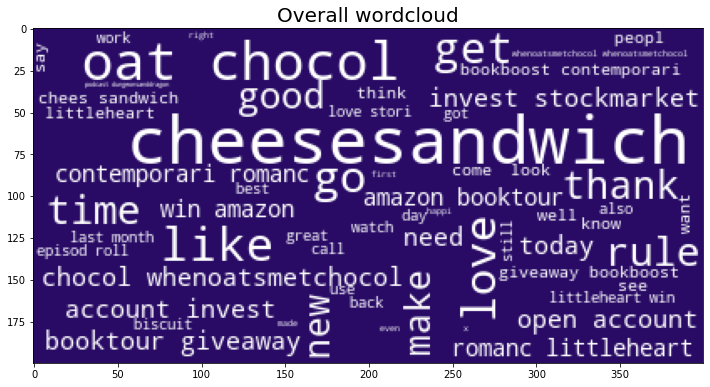

In [62]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(['u','would'])

# Set the background color to dark blue
background_color = '#290B66'

# Set the text color to white
text_color = 'white'

# Set the maximum number of words to 40
max_words = 60

wordcloud = WordCloud(stopwords=stop_words, background_color=background_color, color_func=lambda *args, **kwargs: text_color, max_words=max_words).generate(df['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.title('Overall wordcloud',fontsize=20)
plt.show()

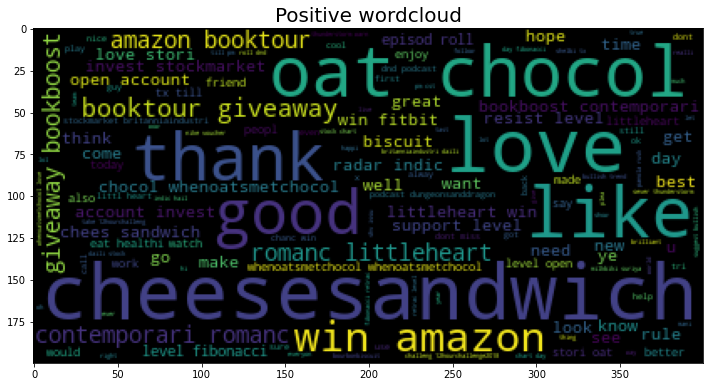

In [39]:
stop_words = set(nltk.corpus.stopwords.words('english'))
#stop_words.update(['nestl', 'nestleindia', 'nestleind','amp','rt','morn','rt','morn','one'])
wordcloud = WordCloud(stopwords=stop_words).generate(df[df['Polarity']=='positive']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.title('Positive wordcloud',fontsize=20)
plt.show()

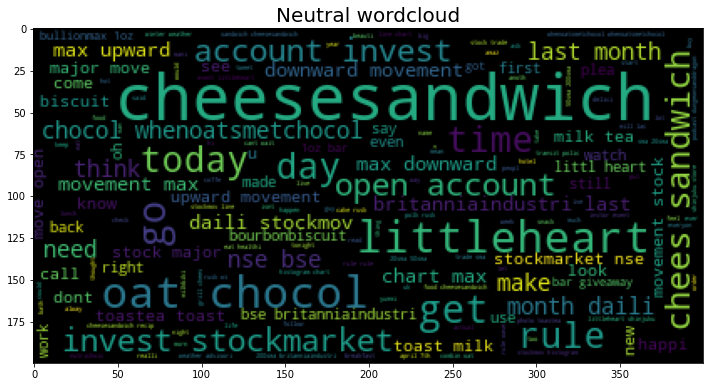

In [48]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(['nestl', 'nestleindia','amp','rt','via','camat'])
wordcloud = WordCloud(stopwords=stop_words).generate(df[df['Polarity']=='neutral']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.title('Neutral wordcloud',fontsize=20)
plt.show()

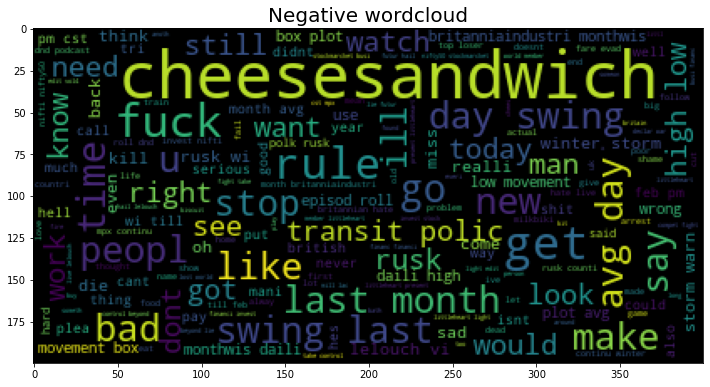

In [49]:
stop_words = set(nltk.corpus.stopwords.words('english'))
wordcloud = WordCloud(stopwords=stop_words).generate(df[df['Polarity']=='negative']['Text'].str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.title('Negative wordcloud',fontsize=20)
plt.show()

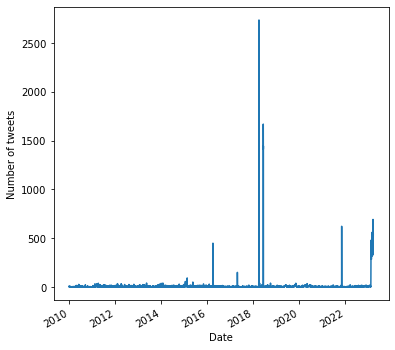

In [50]:
# Distribution of tweets over time
plt.figure(figsize=(6,6))
df['Date'].value_counts().plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.show()

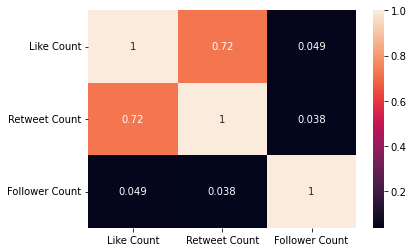

In [51]:
# Create correlation matrix
corr = df[['Like Count', 'Retweet Count', 'Follower Count', 'Polarity']].corr()

# Create heatmap
sns.heatmap(corr, annot=True)
plt.show()

In [52]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize

# Preprocess text data
preprocessed_data = []
for text in df['Text']:
    tokens = word_tokenize(text.lower())
    preprocessed_data.append(tokens)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_data)
corpus = [dictionary.doc2bow(text) for text in preprocessed_data]

# Train the LDA model
num_topics = 1
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print the topics
for topic_id, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
    print("Topic:", topic_id)
    for word, weight in topic:
        print("\t", word, ":", weight)


Topic: 0
	 rusk : 0.03636948
	 cheesesandwich : 0.02040934
	 pm : 0.0046057138
	 chees : 0.004593363
	 sandwich : 0.004226423
	 get : 0.0038943249
	 like : 0.003864723
	 tx : 0.0037922505
	 counti : 0.0036914924
	 wi : 0.0035690058


<AxesSubplot:>

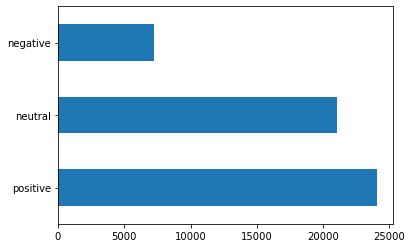

In [53]:
df['Polarity'].value_counts().plot(kind='barh')

### DAILY DATA

In [54]:
# convert the 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [55]:
# group the tweets by day and count the number of tweets in each group
tweet_count = df.groupby(df['Date'].dt.date).size().reset_index(name='count')

min = tweet_count.min()[1]
max = tweet_count.max()[1]
mean = tweet_count.mean()[0]

print('Minimum count:',min,' Maximum count:', max,' Mean count:',mean)

Minimum count: 1  Maximum count: 2735  Mean count: 11.46590659942995


C:\Users\HP\AppData\Local\Temp/ipykernel_11540/3200270126.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = tweet_count.mean()[0]


In [56]:
tweet_volume = tweet_count['count']

In [57]:
# Calculate the weighted sentiment score for each tweet
df['Weighted_Sentiment_Score'] = df['sentiment_score'] * (df['Like Count'] + df['Retweet Count'] + df['Follower Count'])

#df['Weighted_Sentiment_Score'] = df['sentiment_score'] * (df['Follower Count'])

# Group the data by day and calculate the weighted average sentiment score for each day
daily_data = df.groupby(df['Date'].dt.date).agg({'Weighted_Sentiment_Score': 'sum', 'Like Count': 'sum', 'Retweet Count': 'sum', 'Follower Count': 'sum'}).reset_index()

# Calculate daily avg. score considering follower count as weights
daily_data['Daily_Avg_Sentiment_Score'] = daily_data['Weighted_Sentiment_Score'] / (daily_data['Follower Count'])


In [58]:
daily_data['Tweet Volume'] = tweet_volume
daily_data = daily_data.drop('Weighted_Sentiment_Score', axis=1)
daily_data.head()

,Date,Like Count,Retweet Count,Follower Count,Daily_Avg_Sentiment_Score,Tweet Volume
0,2010-01-01,0.0,0.0,1863.0,0.209339,8
1,2010-01-03,0.0,0.0,176.0,0.000000,1
2,2010-01-04,0.0,0.0,282.0,0.000000,2
3,2010-01-05,0.0,0.0,352.0,-0.087850,2
4,2010-01-06,0.0,0.0,352.0,-0.229400,2


In [59]:
# define a function to map the sentiment scores to categories
def get_sentiment_category(score):
    if score > 0:
        return 'positive'
    else:
        return 'negative'

# map the sentiment scores to categories and create a new 'category' column
daily_data['Polarity'] = daily_data['Daily_Avg_Sentiment_Score'].apply(get_sentiment_category)

# print the first 10 rows of the dataframe to verify the results
daily_data.head(10)

,Date,Like Count,Retweet Count,Follower Count,Daily_Avg_Sentiment_Score,Tweet Volume,Polarity
0,2010-01-01,0.0,0.0,1863.0,0.209339,8,positive
1,2010-01-03,0.0,0.0,176.0,0.000000,1,negative
2,2010-01-04,0.0,0.0,282.0,0.000000,2,negative
3,2010-01-05,0.0,0.0,352.0,-0.087850,2,negative
4,2010-01-06,0.0,0.0,352.0,-0.229400,2,negative
5,2010-01-08,0.0,0.0,352.0,-0.443000,2,negative
6,2010-01-09,0.0,0.0,380.0,0.431000,1,positive
7,2010-01-10,0.0,0.0,528.0,-0.014533,3,negative
8,2010-01-11,0.0,0.0,2140.0,0.229172,11,positive
9,2010-01-12,0.0,0.0,528.0,0.146800,3,positive


In [60]:
#daily_data.to_csv('Britannia Daily.csv')